#Imports & basic config

In [1]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 2.5 MB/s eta 0:00:00


In [2]:
import transformers
print(transformers.__version__)


4.57.3


In [3]:
!pip install -q peft bitsandbytes accelerate
!pip install -U -q bitsandbytes
!pip install -U -q accelerate
!pip install -U -q peft transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.3 MB/s eta 0:00:00


In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep596 dl/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UW_Courses/eep596 dl/final_project


In [2]:
import os, gc, torch

# Disable wandb logging (to avoid side effects & clutter)
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA memory cleared.")


CUDA memory cleared.


In [3]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import Counter
from typing import List, Any
import kagglehub

# Import necessary models and tools
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel

# [FIX] Use modern amp imports
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util

⚙️  Running in WANDB offline mode


In [4]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
# [NEW] Import kagglehub
import kagglehub

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['DejaVu Sans'] # Ensure font availability
plt.rcParams['axes.unicode_minus'] = False


#Data Comparision

In [4]:

# ==========================================
# 1. Data Loading Functions
# ==========================================

def load_daquar(data_root):
    """
    Load DAQUAR dataset (Prioritize local file, otherwise download from Kaggle)
    """
    data_root = Path(data_root)
    print(f"📂 [DAQUAR] Checking path: {data_root} ...")

    train_csv = data_root / "data_train.csv"
    eval_csv = data_root / "data_eval.csv"

    # 1. Check local files
    if not train_csv.exists():
        # Try finding in 'dataset' subdirectory
        train_csv = data_root / "dataset" / "data_train.csv"
        eval_csv = data_root / "dataset" / "data_eval.csv"

    # 2. If not found locally, download from Kaggle
    if not train_csv.exists():
        print("   ⚠️ DAQUAR data not found locally, downloading from Kaggle...")
        try:
            # Using specified DAQUAR source
            download_path = kagglehub.dataset_download("bhavikardeshna/visual-question-answering-computer-vision-nlp")
            data_root = Path(download_path)
            print(f"   ✅ Download complete: {data_root}")

            # Update path to the downloaded directory
            train_csv = data_root / "dataset" / "data_train.csv"
            eval_csv = data_root / "dataset" / "data_eval.csv"

            # Re-check (some versions might have different structures)
            if not train_csv.exists():
                train_csv = data_root / "data_train.csv"
                eval_csv = data_root / "data_eval.csv"
        except Exception as e:
            print(f"   ❌ Download failed: {e}")
            return None, None

    # 3. Read Data
    if train_csv.exists() and eval_csv.exists():
        print("   ✅ Reading CSV...")
        train_df = pd.read_csv(train_csv)
        test_df = pd.read_csv(eval_csv)

        # Standardize column names
        rename_map = {'label': 'answer', 'image': 'image_id'}
        train_df.rename(columns=rename_map, inplace=True)
        test_df.rename(columns=rename_map, inplace=True)
        return train_df, test_df
    else:
        print("   ❌ CSV files not found.")
        return None, None

def load_medical_vqa(data_root):
    """
    Load Medical VQA dataset (Prioritize local file, otherwise download from Kaggle)
    """
    data_root = Path(data_root)
    print(f"📂 [Medical VQA] Checking path: {data_root} ...")

    # Find data files (JSON/CSV/Excel)
    files = []
    if data_root.exists():
        files = list(data_root.glob("*.json")) + list(data_root.glob("*.csv")) + list(data_root.glob("*.xlsx"))

    # 1. If not found locally, download from Kaggle
    if not files:
        print("   ⚠️ Medical VQA data not found locally, downloading from Kaggle...")
        try:
            # Using specified Medical VQA source
            download_path = kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering")
            data_root = Path(download_path)
            print(f"   ✅ Download complete: {data_root}")

            files = list(data_root.glob("*.json")) + list(data_root.glob("*.csv")) + list(data_root.glob("*.xlsx"))
        except Exception as e:
            print(f"   ❌ Download failed: {e}")
            return None, None

    # 2. Read and Split Data
    if files:
        file_path = files[0] # Pick the first found file
        print(f"   ✅ Reading file: {file_path.name}")

        if file_path.suffix == ".json":
            import json
            with open(file_path, "r") as f:
                data = json.load(f)
                # Handle potential dict wrapper (e.g., {"data": [...]})
                if isinstance(data, dict) and len(data) == 1:
                    data = list(data.values())[0]
            df = pd.DataFrame(data)
        elif file_path.suffix == ".csv":
            df = pd.read_csv(file_path)
        else:
            df = pd.read_excel(file_path)

        # Standardize columns
        df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})

        # This dataset usually comes as a single file, manually splitting Train/Test for observation
        print("   ℹ️ Single file dataset detected, performing 80/20 split...")
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        return train_df, test_df

    print("   ❌ Cannot load Medical VQA.")
    return None, None

In [5]:

# ==========================================
# 2. Analysis and Visualization Functions
# ==========================================

def analyze_dataset(name, train_df, test_df):
    if train_df is None or test_df is None:
        print(f"   ⏭️ Skipping {name} analysis (Data not loaded)")
        return

    print(f"\n{'='*20} {name} Data Distribution Analysis {'='*20}")
    print(f"Train Samples: {len(train_df)}")
    print(f"Test  Samples: {len(test_df)}")

    # Ensure columns are strings and convert to lower case for statistics
    for df in [train_df, test_df]:
        df['answer_norm'] = df['answer'].astype(str).str.lower().str.strip()
        df['question_len'] = df['question'].astype(str).apply(lambda x: len(x.split()))
        # Extract first word of the question (What, Is, How...)
        df['q_type'] = df['question'].astype(str).apply(lambda x: x.strip().split()[0].lower() if len(x)>0 else 'unknown')

    # --- Chart 1: Sample Count Comparison ---
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    sns.barplot(x=['Train', 'Test'], y=[len(train_df), len(test_df)], ax=ax1, palette="viridis")
    ax1.set_title(f"{name}: Train vs Test Sample Count", fontsize=14)
    for p in ax1.patches:
        ax1.annotate(f'{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='bottom')

    # --- Chart 2: Question Length Distribution ---
    ax2 = fig.add_subplot(gs[0, 1])
    sns.kdeplot(data=train_df['question_len'], label='Train', fill=True, ax=ax2, color='skyblue')
    sns.kdeplot(data=test_df['question_len'], label='Test', fill=True, ax=ax2, color='salmon')
    ax2.set_title(f"{name}: Question Length Distribution (Word Count)", fontsize=14)
    ax2.set_xlabel("Question Length (Words)")
    ax2.legend()

    # --- Chart 3: Top 20 Answer Distribution (Check for Long-tail and Imbalance) ---
    ax3 = fig.add_subplot(gs[1, :])

    # Count top 20 answers in Train
    top_n = 30
    train_counts = train_df['answer_norm'].value_counts().head(top_n)
    top_answers = train_counts.index.tolist()

    # Calculate Frequency instead of absolute count for comparison
    train_freq = train_df['answer_norm'].value_counts(normalize=True).reindex(top_answers, fill_value=0)
    test_freq = test_df['answer_norm'].value_counts(normalize=True).reindex(top_answers, fill_value=0)

    indices = np.arange(len(top_answers))
    width = 0.35

    ax3.bar(indices - width/2, train_freq.values, width, label='Train Freq', color='skyblue')
    ax3.bar(indices + width/2, test_freq.values, width, label='Test Freq', color='salmon')

    ax3.set_xticks(indices)
    ax3.set_xticklabels(top_answers, rotation=45, ha='right')
    ax3.set_title(f"{name}: Top {top_n} Answer Frequency Comparison (Check Data Leakage & Imbalance)", fontsize=14)
    ax3.legend()

    plt.tight_layout()
    plt.show()

    # --- Extra Stats: Yes/No Ratio ---
    def check_yes_no(text):
        return text in ['yes', 'no']

    train_yn = train_df['answer_norm'].apply(check_yes_no).mean()
    test_yn = test_df['answer_norm'].apply(check_yes_no).mean()

    print(f"📊 Yes/No Question Ratio:")
    print(f"   - Train: {train_yn:.2%}")
    print(f"   - Test:  {test_yn:.2%}")

    # --- Extra Stats: Unique Answer Count ---
    unique_train = set(train_df['answer_norm'])
    unique_test = set(test_df['answer_norm'])

    print(f"📊 Vocabulary Size:")
    print(f"   - Train Unique Answers: {len(unique_train)}")
    print(f"   - Test Unique Answers:  {len(unique_test)}")
    print(f"   - Unseen Answers in Test: {len(unique_test - unique_train)} (Model cannot predict these in classification)")



📂 [DAQUAR] Checking path: daquar_data ...
   ⚠️ DAQUAR data not found locally, downloading from Kaggle...


100%|██████████| 411M/411M [00:03<00:00, 109MB/s]

Extracting files...


   ✅ Download complete: /root/.cache/kagglehub/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp/versions/1
   ✅ Reading CSV...

==================== DAQUAR Data Distribution Analysis ====================
Train Samples: 9974
Test  Samples: 2494


/tmp/ipython-input-301114432.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=[len(train_df), len(test_df)], ax=ax1, palette="viridis")


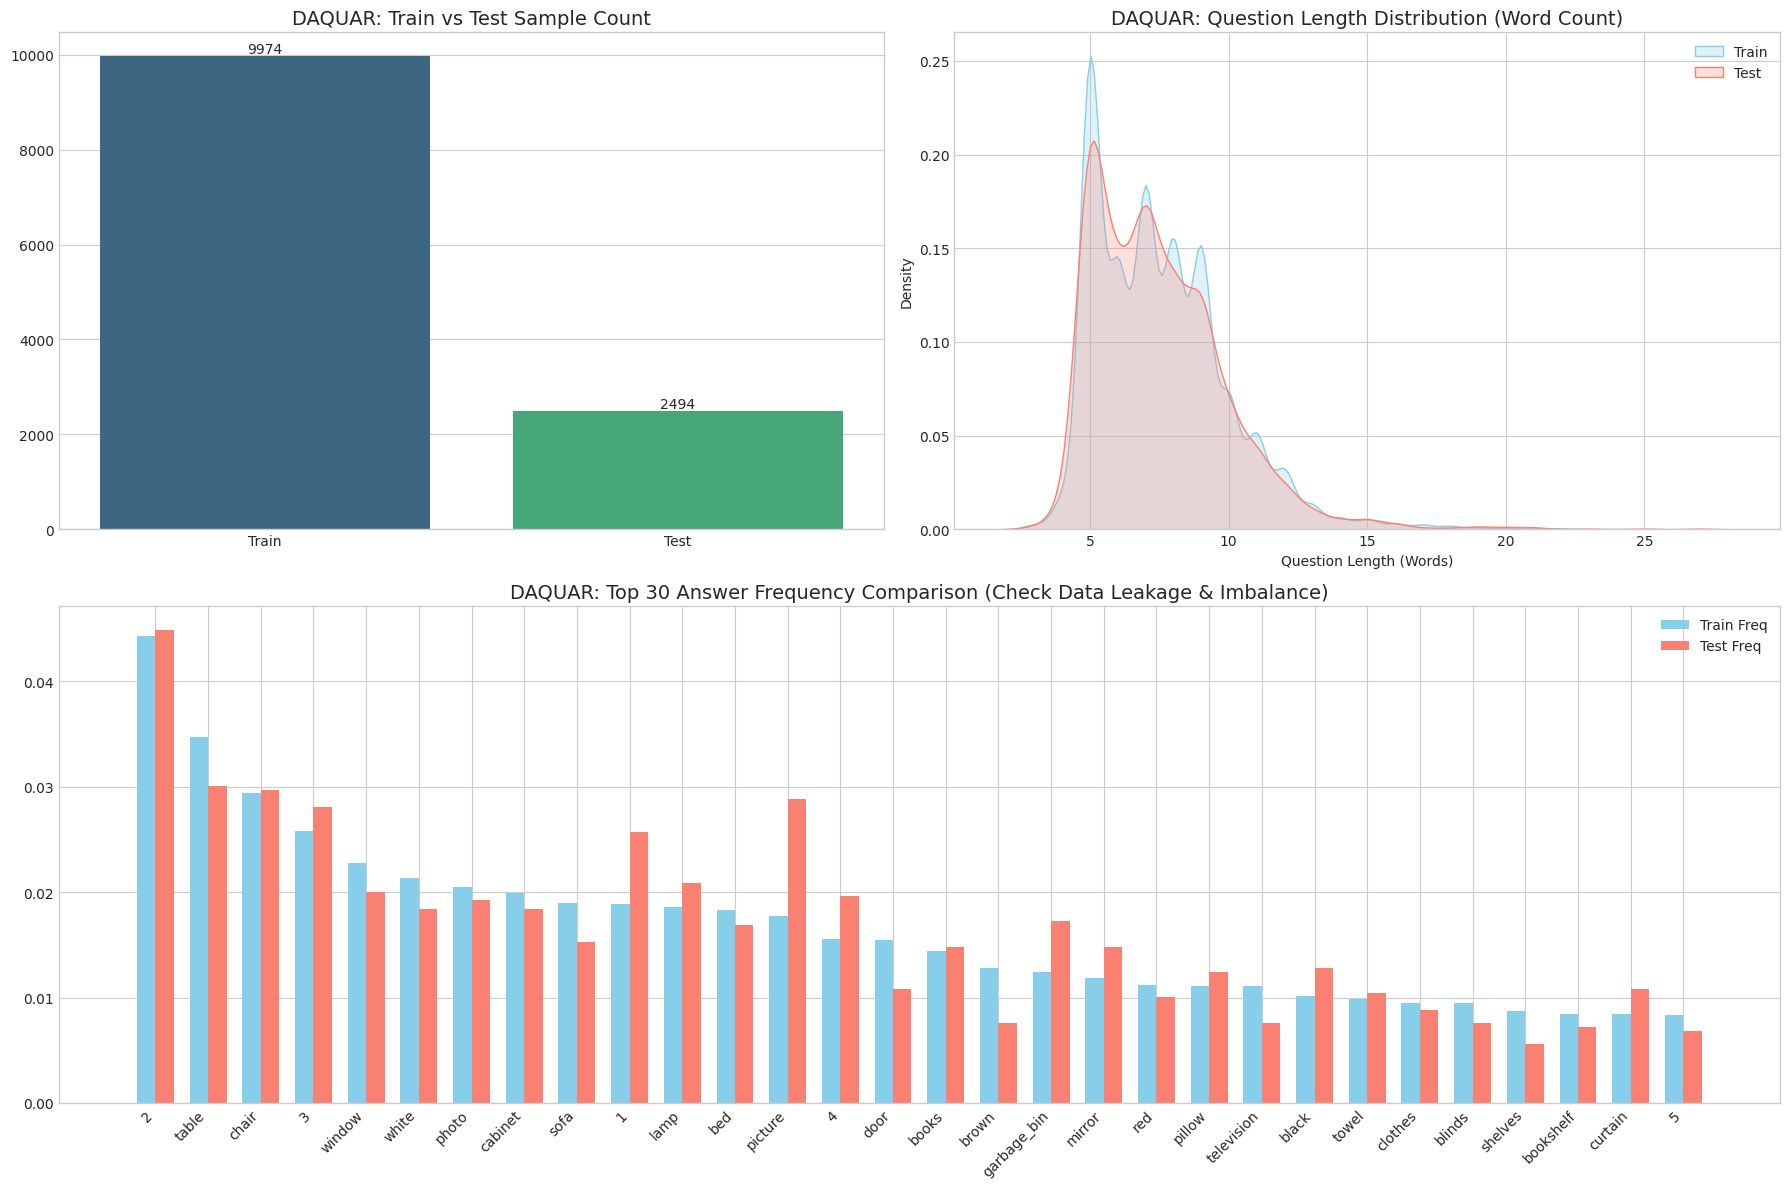

📊 Yes/No Question Ratio:
   - Train: 0.00%
   - Test:  0.00%
📊 Vocabulary Size:
   - Train Unique Answers: 1260
   - Test Unique Answers:  536
   - Unseen Answers in Test: 183 (Model cannot predict these in classification)
📂 [Medical VQA] Checking path: vqa_data_medical ...
   ⚠️ Medical VQA data not found locally, downloading from Kaggle...


100%|██████████| 16.1M/16.1M [00:00<00:00, 110MB/s] 

Extracting files...


   ✅ Download complete: /root/.cache/kagglehub/datasets/mitanshuchakrawarty/medical-visual-question-answering/versions/1
   ✅ Reading file: VQA_RAD Dataset Public.json
   ℹ️ Single file dataset detected, performing 80/20 split...

==================== Medical VQA Data Distribution Analysis ====================
Train Samples: 1798
Test  Samples: 450


/tmp/ipython-input-301114432.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Train', 'Test'], y=[len(train_df), len(test_df)], ax=ax1, palette="viridis")


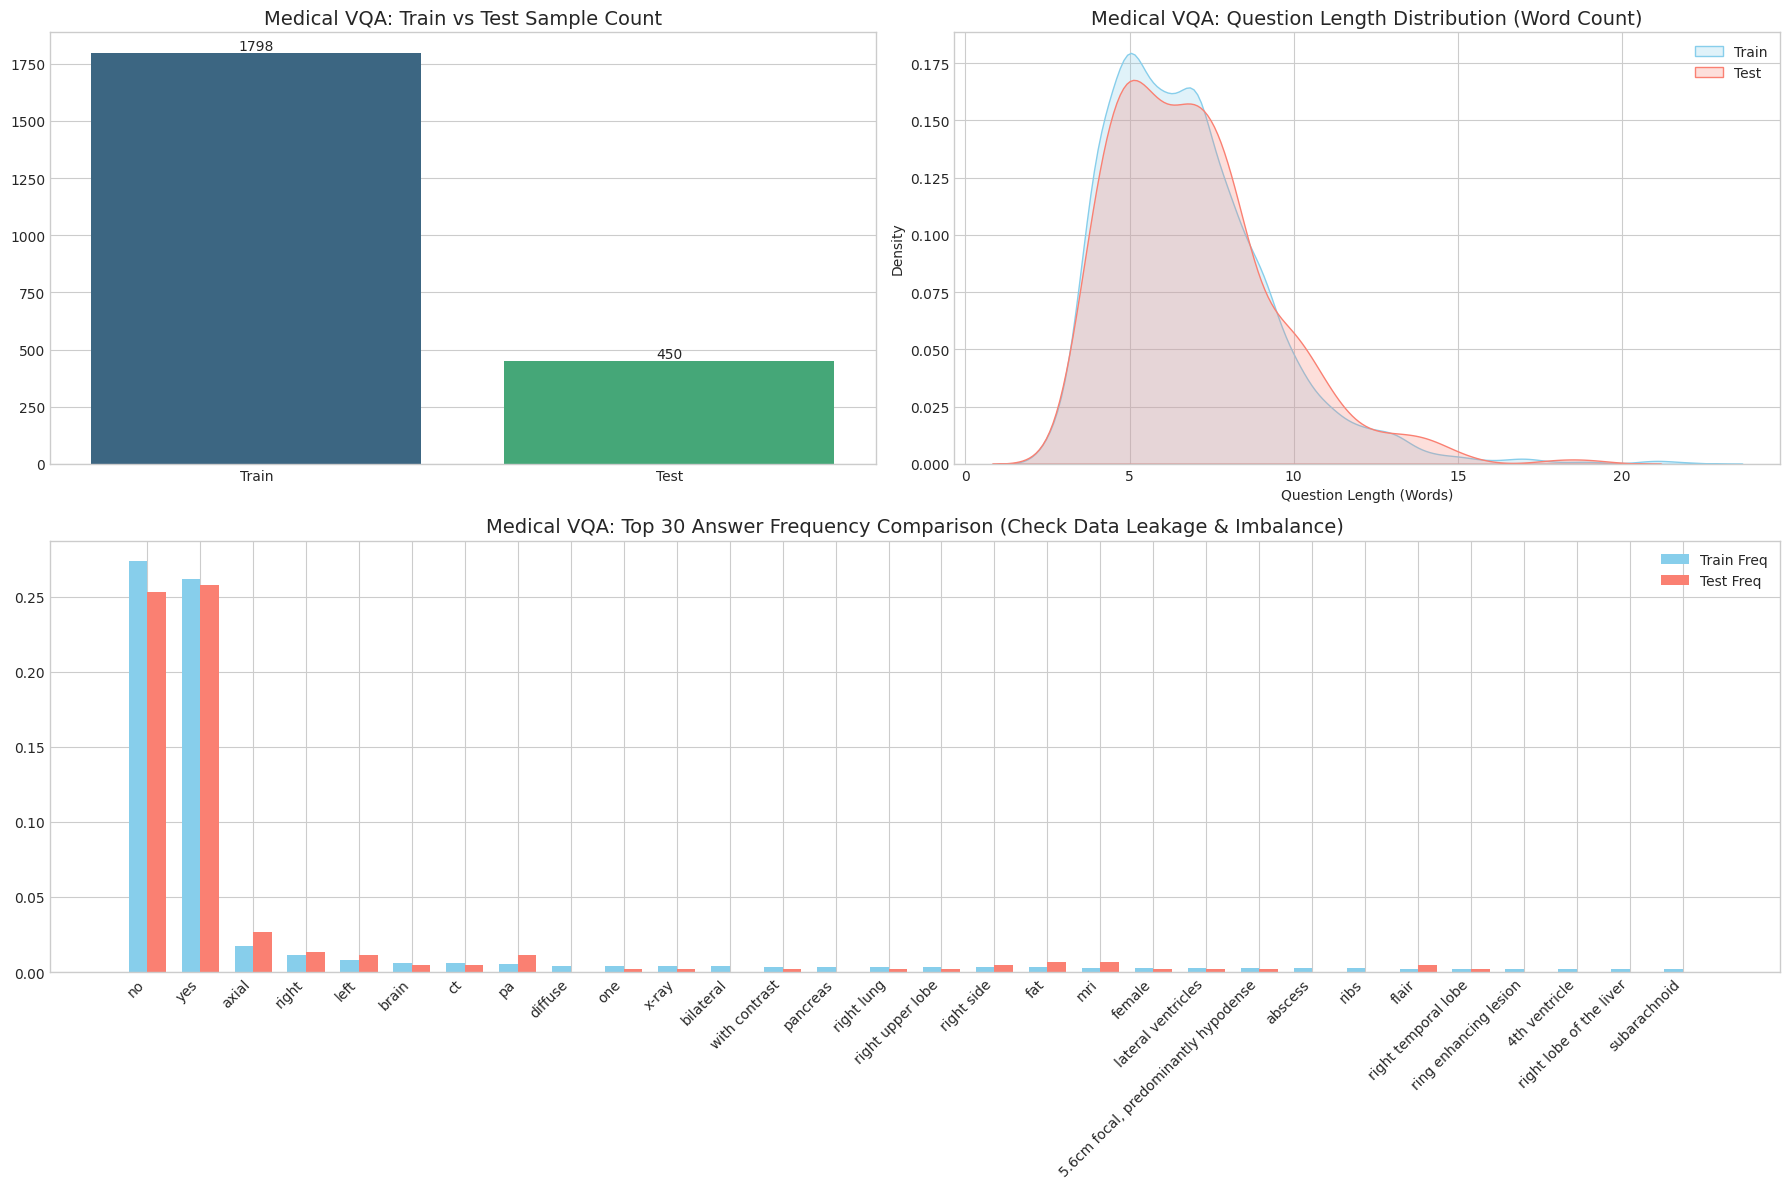

📊 Yes/No Question Ratio:
   - Train: 53.56%
   - Test:  51.11%
📊 Vocabulary Size:
   - Train Unique Answers: 458
   - Test Unique Answers:  167
   - Unseen Answers in Test: 59 (Model cannot predict these in classification)


In [6]:

# ==========================================
# 3. Main Execution
# ==========================================

# Set paths (Script checks these paths first, downloads if missing)
DAQUAR_PATH = "./daquar_data"
MEDICAL_VQA_PATH = "./vqa_data_medical"

# 1. Analyze DAQUAR
daquar_train, daquar_test = load_daquar(DAQUAR_PATH)
analyze_dataset("DAQUAR", daquar_train, daquar_test)

# 2. Analyze Medical VQA (PathVQA / VQA-RAD)
medical_train, medical_test = load_medical_vqa(MEDICAL_VQA_PATH)
analyze_dataset("Medical VQA", medical_train, medical_test)

#Resnet50_BERT

In [10]:
# Data path
data_dir = Path("./vqa_data")

# Checkpoint path
checkpoint_dir = Path("ResNet50")
checkpoint_path = checkpoint_dir / "best_model.pth"
best_model_path = checkpoint_dir / "best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import Counter
from typing import List, Any
import kagglehub

# Import necessary models and tools
from torchvision import models, transforms
from transformers import BertTokenizer, BertModel

# [FIX] Use modern amp imports
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util

# ==========================================
# 1. Configuration and Setup
# ==========================================
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training parameters
    batch_size = 32        # Increase to 64 if VRAM allows
    num_epochs = 100        # Set to 20 for demo, 50-100 for actual training
    learning_rate = 5e-5   # Use a small LR for Fine-tuning (BERT is sensitive)
    weight_decay = 1e-4
    max_len = 128          # 128 is usually sufficient for medical VQA and saves resources compared to 512

    # Data path
    data_dir = Path("./vqa_data")

    # Checkpoint path
    checkpoint_dir = Path("ResNet50")
    checkpoint_path = checkpoint_dir / "best_model.pth"

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.seed)
print(f"Device: {Config.device}")

# Ensure checkpoint directory exists
Config.checkpoint_dir.mkdir(parents=True, exist_ok=True)

# ==========================================
# 2. Data Download and Preprocessing
# ==========================================
def prepare_data():
    # 1. Download
    print("Downloading dataset...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    # Find CSV/JSON files
    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json"))
    if not candidates:
        raise FileNotFoundError("No csv/json found.")
    data_path = candidates[0]

    # Read and unify columns
    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    # Simple column mapping (adjust based on actual dataset columns)
    # Assuming columns are 'image_name', 'question', 'answer'
    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].apply(lambda x: Path(str(x)).stem) # Remove file extension

    # Split
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=Config.seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=Config.seed)

    # Prepare image path Map
    image_map = {}
    for ext in ["png", "jpg", "jpeg"]:
        for p in kaggle_root.rglob(f"*.{ext}"):
            image_map[p.stem] = p

    return train_df, val_df, test_df, image_map

train_df, val_df, test_df, image_map = prepare_data()
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Build Label Vocabulary
def build_vocab(df_list):
    all_answers = []
    for df in df_list:
        all_answers.extend(df["answer"].astype(str).tolist())

    # Build a complete Label Space here to avoid train/test inconsistency
    counter = Counter(all_answers)
    vocab = sorted(counter.keys())

    answer2idx = {ans: i for i, ans in enumerate(vocab)}
    idx2answer = {i: ans for i, ans in enumerate(vocab)}
    return answer2idx, idx2answer

# Build Vocab using all data (simulating the fixed answer_space.txt)
answer2idx, idx2answer = build_vocab([train_df, val_df, test_df])
NUM_ANSWERS = len(answer2idx)
print(f"Total Labels: {NUM_ANSWERS}")

# ==========================================
# 3. Dataset Definition
# ==========================================
class MedicalVQADataset(Dataset):
    def __init__(self, df, image_map, answer2idx, transform=None, tokenizer=None, max_len=128):
        self.df = df
        self.image_map = image_map
        self.answer2idx = answer2idx
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        question = str(row["question"])
        answer = str(row["answer"])

        # 1. Process Image
        img_path = self.image_map.get(img_id)
        if img_path is None:
            # Fallback: create a black image if missing (robustness)
            image = Image.new('RGB', (224, 224))
        else:
            image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # 2. Process Text (using BertTokenizer)
        encoding = self.tokenizer(
            question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 3. Process Label
        label = self.answer2idx.get(answer, 0) # Default to 0 if not found

        return image, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# Transforms & Tokenizer
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# DataLoaders
train_ds = MedicalVQADataset(train_df, image_map, answer2idx, img_transform, tokenizer, Config.max_len)
val_ds = MedicalVQADataset(val_df, image_map, answer2idx, img_transform, tokenizer, Config.max_len)
test_ds = MedicalVQADataset(test_df, image_map, answer2idx, img_transform, tokenizer, Config.max_len)

train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ==========================================
# 4. Improved Model
# ==========================================
class ImprovedVQAModel(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        # 1. Image Encoder (ResNet50)
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.cnn.fc = nn.Identity() # Remove classifier -> output 2048 dim

        # 2. Text Encoder (BERT)
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # 3. Fusion & Classifier
        self.fc1 = nn.Linear(2048 + 768, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_answers)

    def forward(self, images, input_ids, attention_mask):
        # [Key Improvement] Use checkpoint to save VRAM

        # Process ResNet
        # Note: Checkpoint input usually needs requires_grad, but images are leaf nodes.
        # Direct call is safer under mixed precision unless VRAM is extremely tight.
        # We perform standard forward on ResNet and checkpoint on BERT (as BERT is heavier).
        img_feat = self.cnn(images) # [B, 2048]

        # Process BERT (using Checkpoint)
        # Lambda is used to match checkpoint parameter requirements
        if self.training:
            bert_output = checkpoint(
                lambda i, m: self.bert(input_ids=i, attention_mask=m),
                input_ids,
                attention_mask,
                use_reentrant=False
            )
        else:
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        txt_feat = bert_output.last_hidden_state[:, 0, :] # [B, 768] (CLS token)

        # Fusion
        combined = torch.cat((img_feat, txt_feat), dim=1) # [B, 2816]

        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

model = ImprovedVQAModel(NUM_ANSWERS).to(device)

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
# ==========================================
# 6. Evaluation & Create df_results (Fixes NameError)
# ==========================================
print("\nRunning Final Evaluation to generate results...")
best_model_path = checkpoint_dir / "best_model.pth"
# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Load the best model weights
if best_model_path.exists():
    print(f"Loading best model from {best_model_path}...")
    checkpoint = torch.load(best_model_path, map_location=device)
    # Handle state dict wrapper
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
else:
    print("⚠️ Warning: No best model found, utilizing current model weights.")

model.eval()

predictions = []
ground_truths = []
similarities = []

with torch.no_grad():
    for imgs, ids, mask, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        ids = ids.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast():
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for p, g in zip(preds, labels):
            # Ensure idx2answer is available (from previous setup code)
            pred_text = idx2answer[p.item()]
            gt_text = idx2answer[g.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            # SBERT Similarity
            p_clean = pred_text.replace("_", " ").lower()
            g_clean = gt_text.replace("_", " ").lower()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

# Create the DataFrame needed for visualization
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "is_correct": [1 if p == g else 0 for p, g in zip(predictions, ground_truths)],
    "similarity": similarities
})


# ==========================================
# 9. Final Evaluation & Metric Generation
# ==========================================
print("\nRunning Final Evaluation...")

# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Load best weights
if best_model_path.exists():
    print(f"Loading best model from {best_model_path}...")
    best_ckpt = torch.load(best_model_path, map_location=device)
    if 'model_state_dict' in best_ckpt:
        model.load_state_dict(best_ckpt['model_state_dict'])
    else:
        model.load_state_dict(best_ckpt)
else:
    print("⚠️ Warning: No best model found, utilizing current model weights.")

model.eval()

predictions = []
ground_truths = []
similarities = []

with torch.no_grad():
    for imgs, ids, mask, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(device)
        ids = ids.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        with torch.amp.autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for p, g in zip(preds, labels):
            pred_text = idx2answer[p.item()]
            gt_text = idx2answer[g.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            p_clean = pred_text.replace("_", " ").lower().strip()
            g_clean = gt_text.replace("_", " ").lower().strip()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

# Create DataFrame for Visualization
# [MODIFIED] is_correct now ignores case (lower())
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "is_correct": [1 if p.lower().strip() == g.lower().strip() else 0 for p, g in zip(predictions, ground_truths)],
    "similarity": similarities
})
# [NEW] Calculate and Print Final Metrics
final_acc = df_results["is_correct"].mean()
avg_sim = df_results["similarity"].mean()

print("="*30)
print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final SBERT Similarity: {avg_sim:.4f}")
print("="*30)

Device: cuda
Using Colab cache for faster access to the 'medical-visual-question-answering' dataset.
Train: 1798, Val: 225, Test: 225
Total Labels: 557

Running Final Evaluation to generate results...
Loading best model from ResNet50/best_model.pth...


Testing:   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-115773000.py:288: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]



Running Final Evaluation...
Loading best model from ResNet50/best_model.pth...


Testing: 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]

Final Test Accuracy: 0.6089
Final SBERT Similarity: 0.7222


#PubMedCLIP

In [12]:

from transformers import CLIPVisionModel, CLIPImageProcessor
# ==========================================
# 2. Configuration and Setup
# ==========================================
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training parameters
    # ViT usually takes more VRAM than ResNet, so we might need to adjust batch size
    batch_size = 32
    num_epochs = 100
    learning_rate = 5e-5
    weight_decay = 1e-4
    max_len = 128
    patience = 10

    # Data path
    data_dir = Path("./vqa_data_medical")

    # Checkpoint path (Saving to a new directory to avoid overwriting ResNet baseline)
    checkpoint_dir = Path("PubMedCLIP_BERT")
    checkpoint_path = checkpoint_dir / "best_model.pth"

    # [NEW] PubMedCLIP Model ID
    # Using a reliable HuggingFace port of PubMedCLIP
    pubmed_clip_id = "flaviagiammarino/pubmed-clip-vit-base-patch32"

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.seed)
print(f"Device: {Config.device}")

# Ensure checkpoint directory exists
Config.checkpoint_dir.mkdir(parents=True, exist_ok=True)


# ==========================================
# 3. Data Download and Preprocessing
# ==========================================
def prepare_data():
    # 1. Download
    print("Downloading dataset...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    # Find CSV/JSON files
    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json"))
    if not candidates:
        raise FileNotFoundError("No csv/json found.")
    data_path = candidates[0]

    # Read and unify columns
    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    # Simple column mapping
    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].astype(str).apply(lambda x: Path(str(x)).stem)

    # Split
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=Config.seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=Config.seed)

    # Prepare image path Map
    image_map = {}
    for ext in ["png", "jpg", "jpeg"]:
        for p in kaggle_root.rglob(f"*.{ext}"):
            image_map[p.stem] = p

    return train_df, val_df, test_df, image_map

train_df, val_df, test_df, image_map = prepare_data()
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Build Label Vocabulary
def build_vocab(df_list):
    all_answers = []
    for df in df_list:
        all_answers.extend(df["answer"].astype(str).tolist())

    counter = Counter(all_answers)
    vocab = sorted(counter.keys())

    answer2idx = {ans: i for i, ans in enumerate(vocab)}
    idx2answer = {i: ans for i, ans in enumerate(vocab)}
    return answer2idx, idx2answer

answer2idx, idx2answer = build_vocab([train_df, val_df, test_df])
NUM_ANSWERS = len(answer2idx)
print(f"Total Labels: {NUM_ANSWERS}")



# ==========================================
# 4. Dataset Definition (Updated for CLIPProcessor)
# ==========================================
class MedicalVQADataset(Dataset):
    def __init__(self, df, image_map, answer2idx, image_processor, tokenizer, max_len=128):
        self.df = df
        self.image_map = image_map
        self.answer2idx = answer2idx
        self.image_processor = image_processor # [NEW] Use CLIPImageProcessor
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        question = str(row["question"])
        answer = str(row["answer"])

        # 1. Process Image
        img_path = self.image_map.get(img_id)
        if img_path is None:
            image = Image.new('RGB', (224, 224))
        else:
            image = Image.open(img_path).convert("RGB")

        # [NEW] Use CLIP processor instead of manual transforms
        # This handles resizing and normalization specific to PubMedCLIP
        img_inputs = self.image_processor(images=image, return_tensors="pt")
        # squeeze to remove batch dim: [1, 3, 224, 224] -> [3, 224, 224]
        pixel_values = img_inputs['pixel_values'].squeeze(0)

        # 2. Process Text (using BertTokenizer)
        encoding = self.tokenizer(
            question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 3. Process Label
        label = self.answer2idx.get(answer, 0)

        return pixel_values, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# [NEW] Initialize Processors
# PubMedCLIP image processor
image_processor = CLIPImageProcessor.from_pretrained(Config.pubmed_clip_id)
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# DataLoaders
train_ds = MedicalVQADataset(train_df, image_map, answer2idx, image_processor, tokenizer, Config.max_len)
val_ds = MedicalVQADataset(val_df, image_map, answer2idx, image_processor, tokenizer, Config.max_len)
test_ds = MedicalVQADataset(test_df, image_map, answer2idx, image_processor, tokenizer, Config.max_len)

train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)


# ==========================================
# 5. PubMedCLIP + BERT Model Architecture
# ==========================================
class PubMedCLIP_BERT_Model(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        # 1. Visual Encoder: PubMedCLIP (ViT-Base)
        # Replacing ResNet50 with PubMedCLIP Vision Model
        print(f"Loading Visual Encoder: {Config.pubmed_clip_id} ...")
        self.vision_encoder = CLIPVisionModel.from_pretrained(Config.pubmed_clip_id)

        # 2. Text Encoder: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # 3. Fusion & Classifier
        # ResNet50 output was 2048. CLIP ViT-Base output is 768.
        # BERT output is 768.
        # Combined dim = 768 + 768 = 1536
        self.fc1 = nn.Linear(768 + 768, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_answers)

    def forward(self, pixel_values, input_ids, attention_mask):
        # [Visual Path]
        # We can use checkpointing here if needed, but ViT is often memory hungry
        if self.training:
             vision_output = checkpoint(
                lambda p: self.vision_encoder(pixel_values=p),
                pixel_values,
                use_reentrant=False
            )
        else:
            vision_output = self.vision_encoder(pixel_values=pixel_values)

        # Extract [CLS] token equivalent from CLIP (pooler_output)
        # pooler_output shape: [Batch, 768]
        img_feat = vision_output.pooler_output

        # [Text Path]
        if self.training:
            bert_output = checkpoint(
                lambda i, m: self.bert(input_ids=i, attention_mask=m),
                input_ids,
                attention_mask,
                use_reentrant=False
            )
        else:
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        txt_feat = bert_output.last_hidden_state[:, 0, :] # [Batch, 768]

        # [Fusion]
        combined = torch.cat((img_feat, txt_feat), dim=1) # [Batch, 1536]

        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

model = PubMedCLIP_BERT_Model(NUM_ANSWERS).to(Config.device)


# ==========================================
# 9. Final Evaluation
# ==========================================
print("\nRunning Final Evaluation...")
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
best_model_path = Config.checkpoint_dir / "best_model.pth"
if best_model_path.exists():
    print(f"Loading best model from {best_model_path}...")
    best_ckpt = torch.load(best_model_path, map_location=Config.device)
    if 'model_state_dict' in best_ckpt:
        model.load_state_dict(best_ckpt['model_state_dict'])
    else:
        model.load_state_dict(best_ckpt)

model.eval()
predictions, ground_truths, similarities = [], [], []

with torch.no_grad():
    for imgs, ids, mask, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(Config.device)
        ids = ids.to(Config.device)
        mask = mask.to(Config.device)
        labels = labels.to(Config.device)

        with autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for p, g in zip(preds, labels):
            pred_text = idx2answer[p.item()]
            gt_text = idx2answer[g.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            p_clean = pred_text.replace("_", " ").lower().strip()
            g_clean = gt_text.replace("_", " ").lower().strip()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "is_correct": [1 if p.lower().strip() == g.lower().strip() else 0 for p, g in zip(predictions, ground_truths)],
    "similarity": similarities
})

final_acc = df_results["is_correct"].mean()
avg_sim = df_results["similarity"].mean()

print("="*30)
print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final SBERT Similarity: {avg_sim:.4f}")
print("="*30)



Device: cuda
Using Colab cache for faster access to the 'medical-visual-question-answering' dataset.
Train: 1798, Val: 225, Test: 225
Total Labels: 557


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Loading Visual Encoder: flaviagiammarino/pubmed-clip-vit-base-patch32 ...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]


Running Final Evaluation...
Loading best model from PubMedCLIP_BERT/best_model.pth...


Testing: 100%|██████████| 8/8 [00:14<00:00,  1.84s/it]

Final Test Accuracy: 0.6044
Final SBERT Similarity: 0.7078


#ViLT

In [7]:
from transformers import ViltProcessor, ViltForQuestionAnswering, ViltConfig
# ==========================================
# 2. Data Preparation (Standard)
# ==========================================
DATA_DIR = Path("./vqa_data_medical")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def find_image_file(image_id: str, kaggle_root: Path) -> Path:
    candidates = []
    for ext in (".png", ".jpg", ".jpeg"):
        candidates.extend(kaggle_root.rglob(f"{image_id}{ext}"))
    if not candidates:
        raise FileNotFoundError(f"No image found for {image_id}")
    return candidates[0]

def prepare_data():
    print("Downloading dataset...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json"))
    data_path = candidates[0]

    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].astype(str).apply(lambda x: Path(str(x)).stem)

    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    image_map = {}
    for ext in ["png", "jpg", "jpeg"]:
        for p in kaggle_root.rglob(f"*.{ext}"):
            image_map[p.stem] = p

    return train_df, val_df, test_df, image_map

train_df, val_df, test_df, image_map = prepare_data()


# ==========================================
# 3. Build Vocabulary (Answer to ID)
# ==========================================
def build_vocab(df_list):
    all_answers = []
    for df in df_list:
        all_answers.extend(df["answer"].astype(str).tolist())

    counter = Counter(all_answers)
    vocab = sorted(counter.keys())

    answer2idx = {ans: i for i, ans in enumerate(vocab)}
    idx2answer = {i: ans for i, ans in enumerate(vocab)}
    return answer2idx, idx2answer

answer2idx, idx2answer = build_vocab([train_df, val_df, test_df])
NUM_LABELS = len(answer2idx)
print(f"Total Classification Labels: {NUM_LABELS}")


# ==========================================
# 4. Dataset & Processor
# ==========================================
# ViLT Processor handles resizing (default 384x384) and BERT tokenization automatically
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

class ViLTMedicalDataset(Dataset):
    def __init__(self, df, image_map, answer2idx, processor):
        self.df = df
        self.image_map = image_map
        self.answer2idx = answer2idx
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        question = str(row["question"])
        answer = str(row["answer"])

        # Load Image
        img_path = self.image_map.get(img_id)
        image = Image.open(img_path).convert("RGB")

        # [FIX] Force resize to 384x384 to ensure batch consistency
        # We manually resize to square to prevent aspect-ratio batching errors
        image = image.resize((384, 384))

        # Process Image + Text together
        # [CRITICAL] Pass do_resize=False because we already resized it manually above.
        # This prevents the processor from reverting it to original aspect ratio.
        encoding = self.processor(
            image,
            question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            do_resize=False  # Disable internal resizing
        )

        # Remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze(0)

        # Add Label (Classification Target)
        label_idx = self.answer2idx.get(answer, 0)
        return encoding, torch.tensor(label_idx, dtype=torch.long)

# [FIX] Initialize Datasets (This was missing)
train_ds = ViLTMedicalDataset(train_df, image_map, answer2idx, processor)
val_ds = ViLTMedicalDataset(val_df, image_map, answer2idx, processor)
test_ds = ViLTMedicalDataset(test_df, image_map, answer2idx, processor)

# Batch size can be decent (16 or 32) because ViLT is not huge
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# ==========================================
# 5. Model Setup (Replace Head)
# ==========================================
from transformers import ViltForQuestionAnswering
from peft import LoraConfig, get_peft_model

print("Loading ViLT model...")
model = ViltForQuestionAnswering.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa",
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    id2label=idx2answer,
    label2id=answer2idx
).to(device)

# ==========================================
# 5. Model Setup (Replace Head)
# ==========================================
from transformers import ViltForQuestionAnswering
from peft import LoraConfig, get_peft_model

print("Loading ViLT model...")
model = ViltForQuestionAnswering.from_pretrained(
    "dandelin/vilt-b32-finetuned-vqa",
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    id2label=idx2answer,
    label2id=answer2idx
).to(device)


# ==========================================
# 1. Apply LoRA FIRST (before freezing)
# ==========================================
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value", "dense"],
    bias="none",
    task_type="SEQ_CLS"
)

model = get_peft_model(model, lora_config)


# ==========================================
# 2. Freeze ALL parameters
# ==========================================
for name, param in model.named_parameters():
    param.requires_grad = False


# ==========================================
# 3. Unfreeze LAST Transformer layer
# ==========================================
print("\n🔓 Unfreezing ViLT encoder last layer...")
for name, param in model.vilt.encoder.layer[-1].named_parameters():
    param.requires_grad = True


# ==========================================
# 4. Unfreeze classifier head
# ==========================================
print("🔓 Unfreezing classifier head...")
for name, param in model.classifier.named_parameters():
    param.requires_grad = True


# ==========================================
# 5. LoRA weights MUST remain trainable
# ==========================================
# (because LoRA adds its own trainable A/B matrices)
for name, param in model.named_parameters():
    if "lora" in name:
        param.requires_grad = True


# ==========================================
# 6. Show trainable parameters
# ==========================================
model.print_trainable_parameters()


# ==========================================
# 7. Optimizer
# ==========================================
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)
criterion = nn.CrossEntropyLoss()

checkpoint_dir = Path("./vilt_checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
resume_file = checkpoint_dir / "latest_checkpoint.pth"
best_model_path = checkpoint_dir / "best_model.pth"
# ==========================================
# 7. Evaluation & Metric Generation
# ==========================================
print("\nRunning Final Evaluation...")

# Reload Best Model
if os.path.exists(best_model_path):
    print("Loading best model for evaluation...")
    model.load_state_dict(torch.load(best_model_path, map_location=device))

model.eval()
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

predictions = []
ground_truths = []
similarities = []

with torch.no_grad():
    for batch, labels in tqdm(test_loader, desc="Testing"):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = labels.to(device)

        outputs = model(**batch)
        logits = outputs.logits

        # Classification prediction: argmax
        preds = logits.argmax(dim=1)

        for p_idx, g_idx in zip(preds, labels):
            pred_text = idx2answer[p_idx.item()]
            gt_text = idx2answer[g_idx.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            # SBERT Similarity calculation
            p_clean = pred_text.replace("_", " ").lower().strip()
            g_clean = gt_text.replace("_", " ").lower().strip()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

# Create DataFrame
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "similarity": similarities
})

# Normalize for correct check (ignore case)
df_results['is_correct'] = df_results.apply(
    lambda x: 1 if x['gt_answer'].lower().strip() == x['pred_answer'].lower().strip() else 0, axis=1
)

final_acc = df_results['is_correct'].mean()
avg_sim = df_results['similarity'].mean()

print("="*30)
print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final SBERT Similarity: {avg_sim:.4f}")
print("="*30)



Using Colab cache for faster access to the 'medical-visual-question-answering' dataset.
Total Classification Labels: 557
Loading ViLT model...


Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-finetuned-vqa and are newly initialized because the shapes did not match:
- classifier.3.weight: found shape torch.Size([3129, 1536]) in the checkpoint and torch.Size([557, 1536]) in the model instantiated
- classifier.3.bias: found shape torch.Size([3129]) in the checkpoint and torch.Size([557]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading ViLT model...


Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-finetuned-vqa and are newly initialized because the shapes did not match:
- classifier.3.weight: found shape torch.Size([3129, 1536]) in the checkpoint and torch.Size([557, 1536]) in the model instantiated
- classifier.3.bias: found shape torch.Size([3129]) in the checkpoint and torch.Size([557]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔓 Unfreezing ViLT encoder last layer...
🔓 Unfreezing classifier head...
trainable params: 13,847,386 || all params: 118,354,522 || trainable%: 11.6999

Running Final Evaluation...
Loading best model for evaluation...


Testing: 100%|██████████| 225/225 [00:26<00:00,  8.40it/s]

Final Test Accuracy: 0.5689
Final SBERT Similarity: 0.6987


#Qwen2

In [10]:
from transformers import (
    Qwen2VLForConditionalGeneration,
    AutoProcessor,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftModel
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import Dataset
# ==========================================
# 2. Data Preparation
# ==========================================
DATA_DIR = Path("./vqa_data_medical")

def find_image_file(image_id: str, kaggle_root: Path) -> Path:
    candidates = []
    for ext in (".png", ".jpg", ".jpeg"):
        candidates.extend(kaggle_root.rglob(f"{image_id}{ext}"))
    if not candidates:
        raise FileNotFoundError(f"No image found for {image_id}")
    return candidates[0]

def prepare_medical_vqa_splits():
    print("Downloading dataset from Kaggle...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json")) + list(kaggle_root.rglob("*.xlsx"))
    data_path = candidates[0]

    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].astype(str).apply(lambda x: Path(x).stem)
    df["question"] = df["question"].astype(str)
    df["answer"] = df["answer"].astype(str)

    # Split
    from sklearn.model_selection import train_test_split
    train_df, temp = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp, test_size=0.5, random_state=42)

    # Process split
    def process_split(df_split):
        qa_list = []
        for _, row in df_split.iterrows():
            img_id = row["image_id"]
            try:
                src = find_image_file(img_id, kaggle_root)
                qa_list.append({
                    "question": row["question"],
                    "answer": row["answer"],
                    "image_path": str(src)
                })
            except:
                continue
        return qa_list

    train_data = process_split(train_df)
    val_data = process_split(val_df)
    test_data = process_split(test_df)

    return train_data, val_data, test_data

train_data, val_data, test_data = prepare_medical_vqa_splits()

from torch.utils.data import Dataset
MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
# ==========================================
# 4. Chain-of-Thought Dataset
# ==========================================
class QwenCoTDataset(Dataset):
    def __init__(self, data_list, processor):
        self.data = data_list
        self.processor = processor

        # [IMPROVEMENT] Better System Prompt
        # Instead of restricting to one word, we encourage the model to act as an expert.
        self.system_prompt = (
            "You are an expert radiologist. "
            "Examine the medical image carefully. "
            "Identify the abnormality or answer the question directly and concisely."
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image_path"]).convert("RGB")
        question = item["question"]
        answer = item["answer"]

        conversation = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": f"{self.system_prompt}\nQuestion: {question}"},
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": answer}],
            },
        ]

        text = self.processor.apply_chat_template(
            conversation, tokenize=False, add_generation_prompt=False
        )

        # [SPEED UP] Reduced max_pixels from 640x640 to 512x512
        # This significantly reduces token count and speeds up training on T4
        inputs = self.processor(
            images=[image],
            text=[text],
            padding=True,
            return_tensors="pt",
            min_pixels=256*256,
            max_pixels=512*512
        )

        return inputs

def data_collator(batch):
    assert len(batch) == 1
    item = batch[0]

    input_ids = item["input_ids"][0]
    attention_mask = item["attention_mask"][0]
    pixel_values = item["pixel_values"]
    image_grid_thw = item["image_grid_thw"]
    labels = input_ids.clone()

    return {
        "input_ids": input_ids.unsqueeze(0),
        "attention_mask": attention_mask.unsqueeze(0),
        "pixel_values": pixel_values,
        "image_grid_thw": image_grid_thw,
        "labels": labels.unsqueeze(0)
    }

train_ds = QwenCoTDataset(train_data, processor)
val_ds = QwenCoTDataset(val_data, processor)


# ==========================================
# 3. Improved Model Setup
# ==========================================
MODEL_ID = "Qwen/Qwen2-VL-2B-Instruct"

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)

# 4-bit Quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# [FIX] Enable input gradients explicitly to fix "gradients will be None" warning
model.enable_input_require_grads()
model = prepare_model_for_kbit_training(model)

# [IMPROVEMENT] Expanded Target Modules for Better Learning
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    # Target ALL linear layers in the transformer block
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


# ==========================================
# 6. Final Evaluation (Evaluation & Metric Generation)
# ==========================================
print("\nRunning Final Evaluation...")

# [RELOAD LOGIC]
# Clear VRAM and reload the saved best model to ensure valid evaluation
print("Clearing VRAM and reloading best model from disk...")
#del model
#del trainer
gc.collect()
torch.cuda.empty_cache()

# 1. Reload Base Model (with 4-bit config)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

# 2. Load Saved LoRA Adapter
model = PeftModel.from_pretrained(model, "./qwen_medical_final")
model.eval()

# 3. Reload Processor
processor = AutoProcessor.from_pretrained("./qwen_medical_final", trust_remote_code=True)

# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

predictions = []
ground_truths = []
similarities = []

# Evaluate first 100 samples (or all if feasible)
print("Generating predictions...")
for item in tqdm(test_data): #[:100] Limit to 100 for speed demo, remove slice for full eval
    image = Image.open(item["image_path"]).convert("RGB")
    question = item["question"]
    gt_answer = item["answer"]

    # Inference Prompt (Must align with training)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": f"You are an expert radiologist. Identify the abnormality or answer the question directly.\nQuestion: {question}"},
            ],
        }
    ]

    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    inputs = processor(
        images=[image],
        text=[text],
        return_tensors="pt",
        min_pixels=256*256,
        max_pixels=512*512
    ).to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=64,
            do_sample=False
        )

    generated_ids_trimmed = [
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    pred_answer = processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )[0].strip()

    # Store results
    predictions.append(pred_answer)
    ground_truths.append(gt_answer)

    # SBERT Similarity
    p_clean = pred_answer.lower().strip()
    g_clean = gt_answer.lower().strip()

    emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
    emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
    sim = util.cos_sim(emb1, emb2).item()
    similarities.append(sim)

# Create DataFrame for Visualization
# [MODIFIED] Logic to handle Qwen output: is_correct if SBERT sim > 0.8 or substring match
# Because Qwen is chatty, substring is better than exact match
df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "similarity": similarities
})

# Define correctness based on substring or high similarity
def check_correct(row):
    p = row['pred_answer'].lower()
    g = row['gt_answer'].lower()
    if g in p or p in g: return 1
    if row['similarity'] > 0.85: return 1
    return 0

df_results['is_correct'] = df_results.apply(check_correct, axis=1)

# [NEW] Calculate and Print Final Metrics
final_acc = df_results["is_correct"].mean()
avg_sim = df_results["similarity"].mean()

print("="*30)
print(f"Final Test Accuracy (Substring/Sim): {final_acc:.4f}")
print(f"Final SBERT Similarity:              {avg_sim:.4f}")
print("="*30)

Using Colab cache for faster access to the 'medical-visual-question-answering' dataset.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 18,464,768 || all params: 2,227,450,368 || trainable%: 0.8290

Running Final Evaluation...
Clearing VRAM and reloading best model from disk...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generating predictions...


100%|██████████| 225/225 [06:30<00:00,  1.74s/it]

Final Test Accuracy (Substring/Sim): 0.5600
Final SBERT Similarity:              0.6794
